In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

## Retrieve the data

In [2]:
data = pd.read_csv('anomaly-data-1', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [3]:
## Get only HTTP data
X = data.loc[data[2]=='http']

## Drop constant categorical variables
X = X.drop(X.columns[[1, 2]], axis=1)
X.shape

(64293, 40)

In [4]:
## Anomaly/label column
X[41].unique()
labels = X[41].values

## Evaluate data quality
Using Pandas Profiling we can generate an extensive data quality report

In [5]:
profile = ProfileReport(X, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

#### The data quality report shows: 
- Variables with constant values
- Highly correlated variables
- No missing values

#### Remove variables with constant values

In [6]:
constant = [e for e in X.columns if X[e].nunique() == 1]
X.drop(constant, axis=1, inplace=True)
constant

[6, 7, 8, 10, 14, 16, 17, 19, 20, 21]

#### Remove highly correlated variables
A trivial approach to remove features with linear correlations greater than 0.95

In [7]:
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X.drop(to_drop, axis=1, inplace=True)
to_drop

[9, 12, 25, 26, 27, 38, 39, 40]

#### Create binary anomaly label vector y

In [8]:
Y = np.where(X[41] != 'normal.', 1, X[41])
Y = np.where(Y == 'normal.', 0, Y)
# Drop label column
X.drop([41], axis=1, inplace=True)
pd.Series(Y).unique()

array([0, 1], dtype=object)

## Prepare data for visualization

In [9]:
### Encode nominal categorical data with one-hot-encoder
onehotencoder = OneHotEncoder()
encoder_df = onehotencoder.fit_transform(X[3].to_frame()).toarray()
X.drop([3], axis=1, inplace=True)
X = pd.DataFrame(np.concatenate([X, encoder_df], axis=1))
X.tail()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
64288,0.0,310.0,1881.0,1.0,0.0,0.0,0.0,4.0,5.0,0.00,...,0.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64289,0.0,282.0,2286.0,1.0,0.0,0.0,0.0,6.0,6.0,0.00,...,0.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64290,0.0,203.0,1200.0,1.0,0.0,0.0,0.0,6.0,18.0,0.17,...,0.05,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64291,0.0,291.0,1200.0,1.0,0.0,0.0,0.0,6.0,12.0,0.00,...,0.05,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64292,0.0,219.0,1234.0,1.0,0.0,0.0,0.0,6.0,35.0,0.00,...,0.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
## Calculate eigenvectors to visualize in 2 dimensions
pca = PCA(n_components=2)
pca.fit(X)
pca_df = pd.DataFrame(pca.transform(X))
print("Eigenvectors explain {:.2f}% of variance.".format(sum(pca.explained_variance_ratio_)*100))

Eigenvectors explain 99.99% of variance.


## Visualize dataset 
PCA and T-SNE

In [11]:
## Calculate T-SNE. Note: When computing TSNE is too costly, lower dimension PCA transformed data should be used instead of the original dataset
tsne = TSNE(n_components=2,       
            perplexity=50)
tsne_df = tsne.fit_transform(X)
print("Kullback-Leibler divergence after optimization {:.2f}%.".format(tsne.kl_divergence_))

Kullback-Leibler divergence after optimization 1.57%.


## 

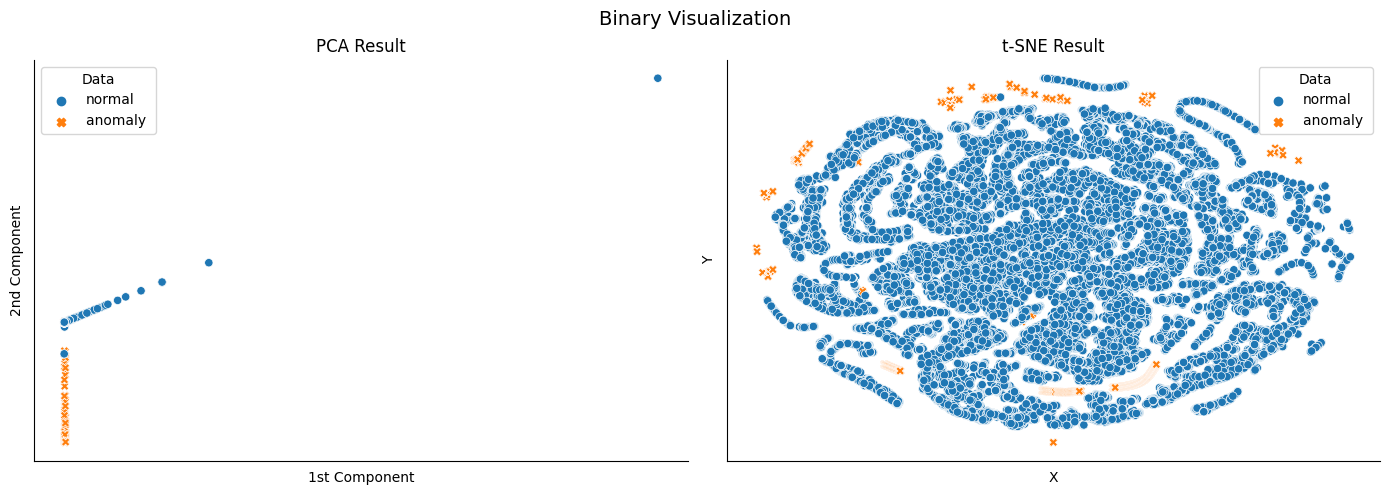

In [12]:
pca_df = pca_df.rename(columns={0: '1st Component', 1: '2nd Component'})
pca_df['Data'] = Y
pca_df['Data'] = pca_df['Data'].apply(lambda x: 'anomaly ' if x==1 else 'normal')

tsne_df = pd.DataFrame(tsne_df, columns=['X', 'Y'])
tsne_df['Data'] = Y
tsne_df['Data'] = tsne_df['Data'].apply(lambda x: 'anomaly ' if x==1 else 'normal')

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_df,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_df,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Binary Visualization', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

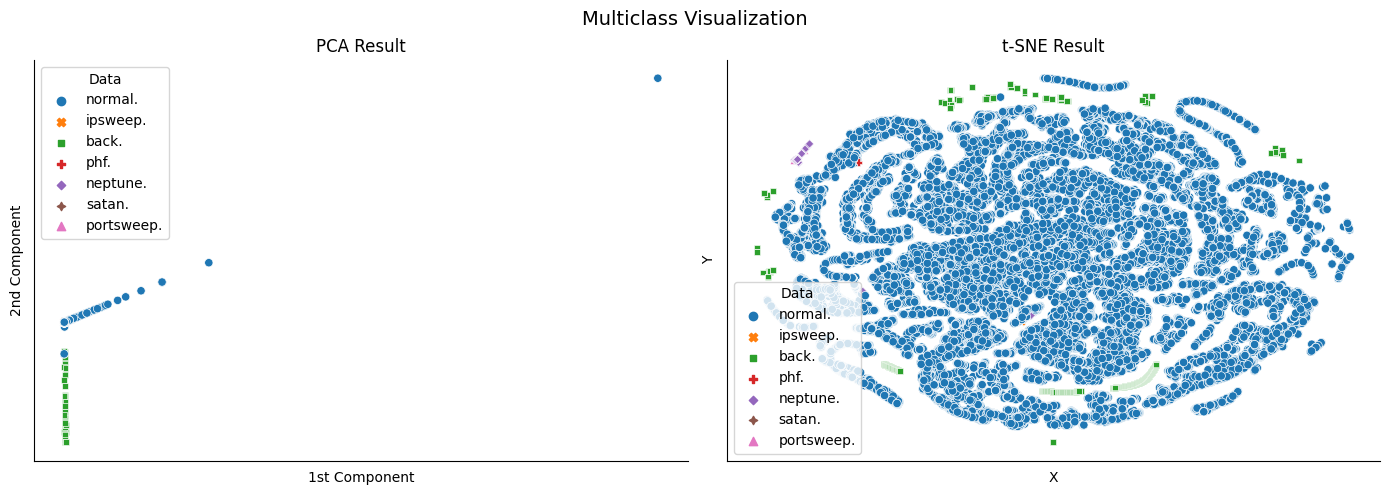

In [13]:
pca_df = pca_df.rename(columns={0: '1st Component', 1: '2nd Component'})
pca_df['Data'] = labels

tsne_df = pd.DataFrame(tsne_df, columns=['X', 'Y'])
tsne_df['Data'] = labels

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_df,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_df,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Multiclass Visualization', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

#### The dataset visualization shows: 
- Majority of anomalies are concentrated in anomaly "clusters" (which is a good sign for anomaly detection)
- Different classes of anomalies seem to share "clusters". This further confirms that in this case it may be better/easier to use a binary classification approach instead of multi-class classification. 

# Detecting Anomalies


## Splitting the dataset in train and test data

In [14]:
Y = pd.DataFrame(Y).astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

## Anomaly detection with Isolation Forest

In [15]:
clf = IsolationForest(max_samples='auto', contamination=.1,                     
                     random_state=19117, max_features=X_train.shape[1]-1)
clf.fit(X_train)

IsolationForest(contamination=0.1, max_features=27, random_state=19117)

### In-sample anomaly detection

In [16]:
y_pred_train = clf.predict(X_train)
## Use 1 as anomaly and 0 as normal.
y_pred_train = np.where(y_pred_train == 1, 0, y_pred_train)
y_pred_train = np.where(y_pred_train == -1, 1, y_pred_train)
y_pred_train = pd.DataFrame(y_pred_train)

In [17]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     42974
           1       0.14      0.32      0.20      2031

    accuracy                           0.88     45005
   macro avg       0.55      0.61      0.57     45005
weighted avg       0.93      0.88      0.90     45005



In [18]:
print(confusion_matrix(y_train, y_pred_train))

[[39117  3857]
 [ 1388   643]]


### Out-of-sample anomaly detection

In [19]:
y_pred_test=clf.predict(X_test)
## Use 1 as anomaly and 0 as normal.
y_pred_test = np.where(y_pred_test == 1, 0, y_pred_test)
y_pred_test = np.where(y_pred_test == -1, 1, y_pred_test)
y_pred_test = pd.DataFrame(y_pred_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85     18912
           1       0.07      1.00      0.13       376

    accuracy                           0.74     19288
   macro avg       0.53      0.87      0.49     19288
weighted avg       0.98      0.74      0.83     19288



In [20]:
print(confusion_matrix(y_test, y_pred_test))

[[13869  5043]
 [    0   376]]


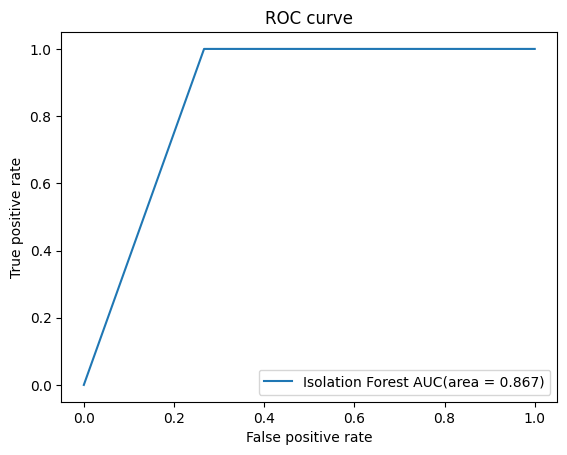

In [21]:
fpr_if, tpr_if, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr_if, tpr_if, label='Isolation Forest AUC(area = {:.3f})'.format(auc(fpr_if, tpr_if)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [22]:
pred = np.concatenate([y_pred_train,y_pred_test], axis=0)

### Anomaly class count in test dataset

In [23]:
## Anomalies in test dataset
p = pd.DataFrame()
p['Real'] = labels[-len(y_test):]
p = p.reset_index(drop=True)
p['Pred'] = y_test.reset_index(drop=True)
p['Real'].loc[p['Pred'] == 1].value_counts()

back.         201
neptune.      169
portsweep.      3
satan.          2
phf.            1
Name: Real, dtype: int64

### Anomaly class count detected for test dataset

In [24]:
## Anomalies in test dataset
p = pd.DataFrame()
p['Real'] = labels[-len(y_test):]
p = p.reset_index(drop=True)
p['Pred'] = y_pred_test
p['Real'].loc[p['Pred'] == 1].value_counts()

normal.       5043
back.          201
neptune.       169
portsweep.       3
satan.           2
phf.             1
Name: Real, dtype: int64

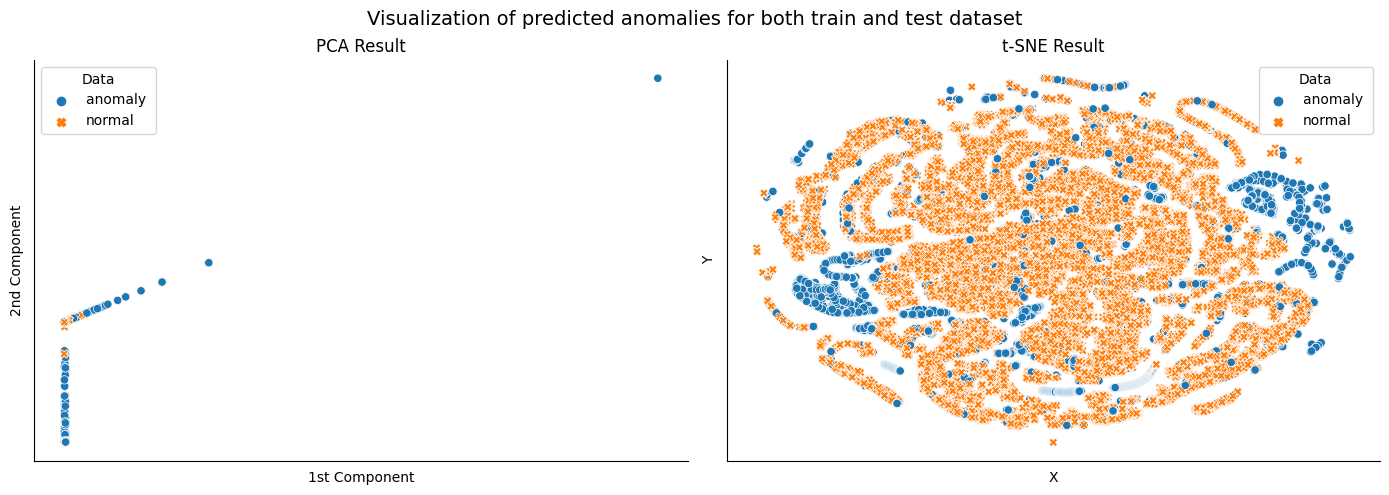

In [25]:
pca_df = pca_df.rename(columns={0: '1st Component', 1: '2nd Component'})
pca_df['Data'] = pred
pca_df['Data'] = pca_df['Data'].apply(lambda x: 'anomaly ' if x==1 else 'normal')

tsne_df = pd.DataFrame(tsne_df, columns=['X', 'Y'])
tsne_df['Data'] = pred
tsne_df['Data'] = tsne_df['Data'].apply(lambda x: 'anomaly ' if x==1 else 'normal')

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_df,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_df,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Visualization of predicted anomalies for both train and test dataset', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

## Anomaly detection with Variational AutoEncoder
Unsupervised VAE using both the reconstruction loss and Kullback-Leibler loss


### Data pre-processing
Contrary to tree models, Neural Networks may benefit from scaling techniques such as the MinMaxScaler. 

In [26]:
scaler = MinMaxScaler()

## First we get the min and max from the training dataset and then we transform it.
X_train_scaled = scaler.fit_transform(X_train)

## Secondly we use the fitted scaler to scale the test dataset.
X_test_scaled = scaler.transform(X_test)

### Creating the VAE model

#### Parameters

In [27]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
## Dimension of intermediate layers of both the Encoder and Decoder
intermediate_dim = int(original_dim / 2)
## Latent space dimension
latent_dim = int(original_dim / 3)

learning_rate = 0.0001
clipvalue = 0.5
epochs = 100
batch_size = 256

#### Encoder
The Encoder will receive the transformed dataset as input and output the mean and log variance that will be used to sample the latent space

##### Define the sample function used by the encoder to sample the latent space

In [28]:
def sample(args):
    z_mean, z_log_var = args   
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    ## epsilon is used to ensure the continuity of the latent space
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [29]:
## Using subclassing instead of a Lambda layer to avoid serialization issues.
class ReparameterizationLayer(Layer):
    def __init__(self, name=''):
        super(ReparameterizationLayer, self).__init__(name=name)
        
    def call(self, inputs):
        return sample(inputs)

In [30]:
## Define the architecture
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
## reparameterization trick and get the output from the sample() function
z = ReparameterizationLayer(name='z')([z_mean, z_log_var])

## Instantiate the encoder model
encoder = tf.keras.Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 14)           406         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 9)            135         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 9)            135         ['dense[0][0]']                  
                                                                                            

#### Decoder
The decoder will receive the sampled latent space as input and (try to) output the original dataset

In [31]:
## Define the architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

## Instantiate the decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 9)]               0         
                                                                 
 dense_1 (Dense)             (None, 14)                140       
                                                                 
 dense_2 (Dense)             (None, 28)                420       
                                                                 
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


#### VAE model

In [32]:
outputs = decoder(encoder(inputs))
vae_model = tf.keras.Model(inputs, outputs, name='vae_mlp')

#### Loss function

In [33]:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    return total_loss

#### Optimizer

In [34]:
opt = optimizers.Adam(learning_rate=learning_rate, clipvalue=clipvalue)

#### VAE model summary

In [35]:
vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28)]              0         
                                                                 
 encoder (Functional)        (None, 9)                 676       
                                                                 
 decoder (Functional)        (None, 28)                560       
                                                                 
Total params: 1,236
Trainable params: 1,236
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [46]:
results = vae_model.fit(X_train_scaled, X_train_scaled,
                        shuffle=True,
                        epochs=epochs,
                        batch_size=batch_size)

Train on 45005 samples
Epoch 1/100
45005/45005 [==============================] - 1s 29us/sample - loss: 5569.9415
Epoch 2/100
45005/45005 [==============================] - 1s 27us/sample - loss: 5467.6010
Epoch 3/100
45005/45005 [==============================] - 1s 27us/sample - loss: 5090.3230
Epoch 4/100
45005/45005 [==============================] - 1s 26us/sample - loss: 4297.1107
Epoch 5/100
45005/45005 [==============================] - 1s 26us/sample - loss: 3346.1693
Epoch 6/100
45005/45005 [==============================] - 1s 26us/sample - loss: 2686.9994
Epoch 7/100
45005/45005 [==============================] - 1s 25us/sample - loss: 2312.7054
Epoch 8/100
45005/45005 [==============================] - 1s 26us/sample - loss: 2178.1404
Epoch 9/100
45005/45005 [==============================] - 1s 26us/sample - loss: 2134.0976
Epoch 10/100
45005/45005 [==============================] - 1s 26us/sample - loss: 2097.1731
Epoch 11/100
45005/45005 [==============================

#### Classify anomalies based on the reconstruction error (MAE)
An error threshold is defined using the 90th percentile of errors calculated using in-sample data. 

In [47]:
def get_mae(v1, v2):
    return np.mean(abs(v1 - v2), axis=1)

array([[<AxesSubplot:title={'center':'MAE Histogram'}>]], dtype=object)

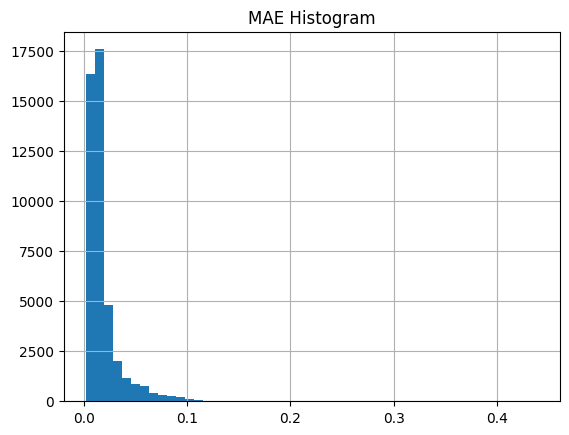

In [48]:
X_train_pred = vae_model.predict(X_train_scaled)
mae_vector = get_mae(X_train_pred, X_train_scaled)
pd.DataFrame(mae_vector, columns=['MAE Histogram']).hist(bins=50)

In [49]:
## Define the error threshold
error_thresh = np.quantile(mae_vector, 0.90)

### Out-of-sample anomaly detection

In [50]:
X_test_pred = vae_model.predict(X_test_scaled)
mae_vector_test = get_mae(X_test_pred, X_test_scaled)
anomalies = (mae_vector_test > error_thresh)

#### Performance

In [51]:
pd.DataFrame(anomalies).value_counts()

False    14185
True      5103
dtype: int64

In [52]:
print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86     18912
           1       0.07      0.93      0.13       376

    accuracy                           0.75     19288
   macro avg       0.53      0.84      0.49     19288
weighted avg       0.98      0.75      0.84     19288



In [53]:
print(confusion_matrix(y_test, anomalies))

[[14159  4753]
 [   26   350]]


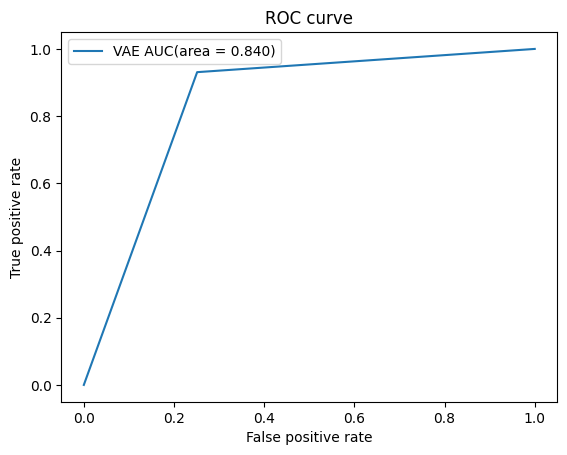

In [54]:
fpr_vae, tpr_vae, thresholds = roc_curve(y_test, anomalies)
plt.plot(fpr_vae, tpr_vae, label='VAE AUC(area = {:.3f})'.format(auc(fpr_vae, tpr_vae)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Visualize anomalies using the latent space

In [55]:
## Get latent space
X_test_encoded = encoder.predict(X_test_scaled)

## Calculate the eigenvectors
pca_vae = PCA(n_components=2)
X_test_pca = pd.DataFrame(pca_vae.fit_transform(X_test_encoded))

## Calculate t-sne
tsne_vae = TSNE(n_components=2,       
            perplexity=50)
X_test_tsne = tsne_vae.fit_transform(X_test_encoded)

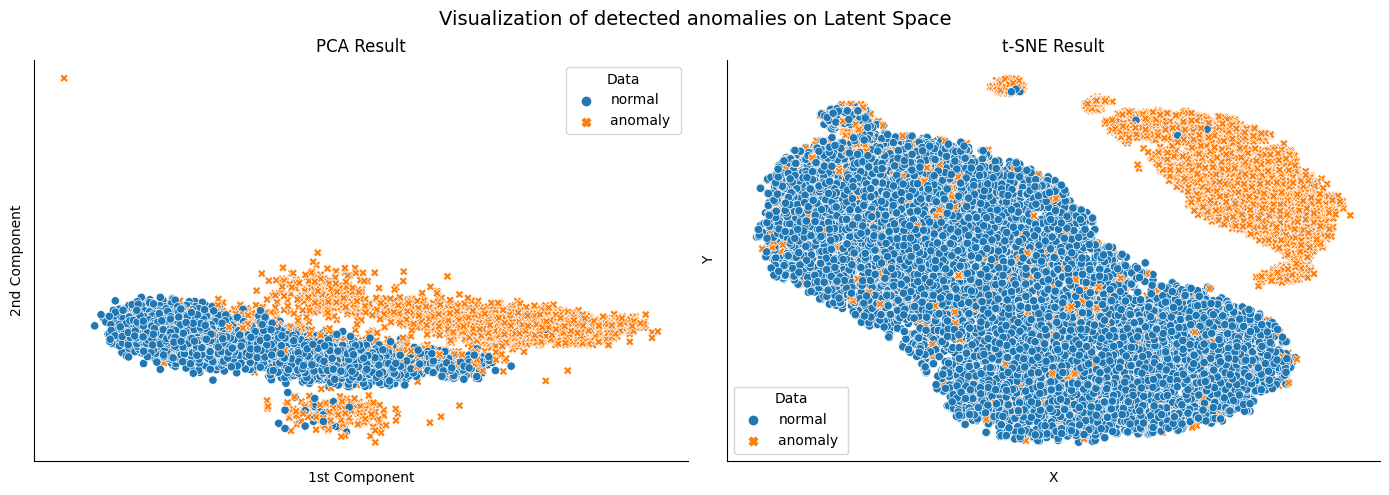

In [56]:
X_test_pca = X_test_pca.rename(columns={0: '1st Component', 1: '2nd Component'})
X_test_pca['Data'] = anomalies
X_test_pca['Data'] = X_test_pca['Data'].apply(lambda x: 'anomaly ' if x is True else 'normal')

X_test_tsne = pd.DataFrame(X_test_tsne, columns=['X', 'Y'])
X_test_tsne['Data'] = anomalies
X_test_tsne['Data'] = X_test_tsne['Data'].apply(lambda x: 'anomaly ' if x is True else 'normal')

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=X_test_pca,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=X_test_tsne,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Visualization of detected anomalies on Latent Space', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

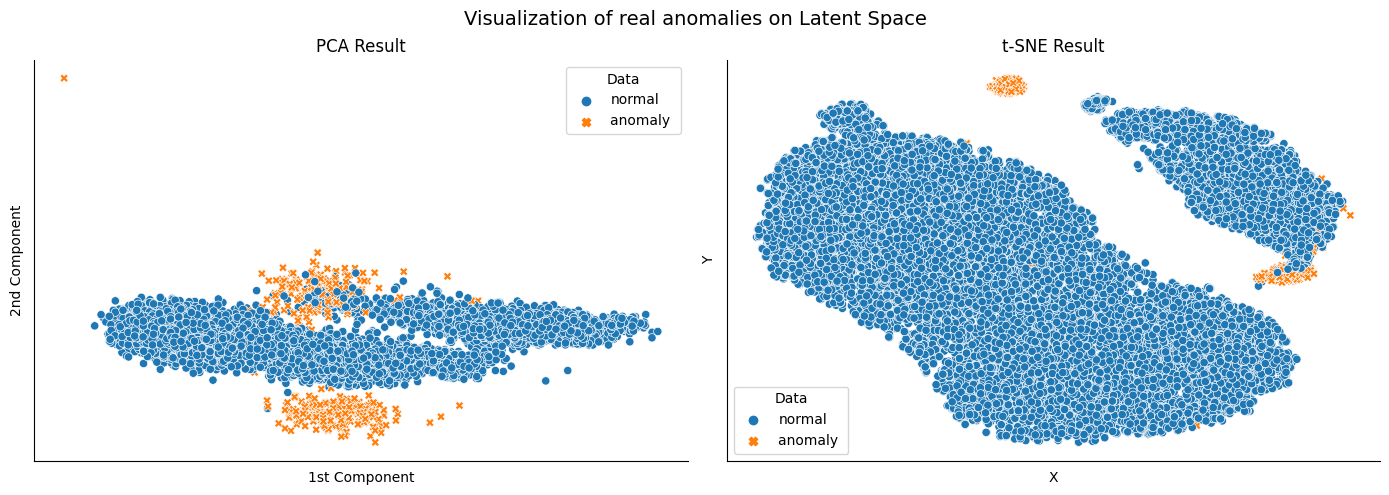

In [57]:
X_test_pca = X_test_pca.rename(columns={0: '1st Component', 1: '2nd Component'})
X_test_pca['Data'] = y_test.values
X_test_pca['Data'] = X_test_pca['Data'].apply(lambda x: 'anomaly ' if x==1 else 'normal')

X_test_tsne = pd.DataFrame(X_test_tsne, columns=['X', 'Y'])
X_test_tsne['Data'] = y_test.values
X_test_tsne['Data'] = X_test_tsne['Data'].apply(lambda x: 'anomaly ' if x==1 else 'normal')

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=X_test_pca,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=X_test_tsne,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Visualization of real anomalies on Latent Space', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

## Comparison of results and final remarks
- Looking at all metrics (Precision, Recall, F1, AUC) and visualizations computed the VAE model is performing better than the Isolation Forest.

### Next steps / Improvements
- Analyze which anomaly classes are harder to detect
- Improve hyperparameter tuning; use AutoML techniques
- Try using a Supervised VAE instead the Unsupervised approach. The goal would be to improve the Precision and avoid having to set a percentile for the "error threshold".  
- Try more complex architectures for the Encoder and Decoder in the VAE model (e.g. using CNN, more intermediate layers, ...) 
- Try Deep Isolation Forests instead of the classic Isolation Forest. (https://arxiv.org/abs/2206.06602)